In [1]:
!gdown https://drive.google.com/uc?id=1-gEcE4mbemeqag3YhUVS0tRWfVjapuwF
!unzip /content/folds.zip

Streaming output truncated to the last 5000 lines.
  inflating: fold4/image/2303.png    
  inflating: fold4/image/2308.png    
  inflating: fold4/image/2310.png    
  inflating: fold4/image/2311.png    
  inflating: fold4/image/2314.png    
  inflating: fold4/image/2317.png    
  inflating: fold4/image/2319.png    
  inflating: fold4/image/2321.png    
  inflating: fold4/image/2322.png    
  inflating: fold4/image/2323.png    
  inflating: fold4/image/2324.png    
  inflating: fold4/image/2325.png    
  inflating: fold4/image/2331.png    
  inflating: fold4/image/2338.png    
  inflating: fold4/image/2341.png    
  inflating: fold4/image/2342.png    
  inflating: fold4/image/2345.png    
  inflating: fold4/image/2346.png    
  inflating: fold4/image/2349.png    
  inflating: fold4/image/2350.png    
  inflating: fold4/image/2357.png    
  inflating: fold4/image/2358.png    
  inflating: fold4/image/2361.png    
  inflating: fold4/image/2366.png    
  inflating: fold4/image/2367.png    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pprint

pp = pprint.PrettyPrinter(indent=4)

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, Subset, DataLoader, random_split, ConcatDataset

parameters = {
    'batch_size': 32,
    'child_counter': 5,
    'children_of_child_counter': 1,
    'neurons': 128,
    'bias': 1,
    'activation': 'relu',
    'loss': 'cross entropy loss',
    'optimizer': 'adamw',
    'layers': 3,
    'learning_rate': 0.001,
    'weight_decay': 0.0001,
    'epochs': 20,
    'mean': (0.6495729088783264,0.6495729088783264,0.6495729088783264),
    'std': (0.2604725658893585,0.2604725658893585,0.2604725658893585),
    'training_loss': [],
    'testing_loss': [],
    'evaluation_accuracy': [],
    'total_accuracy': None
}

# TODO: Construct your data in the following baseline structure: 1) ./Dataset/Train/image/, 2) ./Dataset/Train/label, 3) ./Dataset/Test/image, and 4) ./Dataset/Test/label
class LungDataset(Dataset):
    def __init__(self, root, transform=None):        
        self.root = root
        self.transform = transform

    def __len__(self):
        # Return number of points in the dataset
        imgs_path = os.path.join(self.root, 'image')
        return len(os.listdir(imgs_path))

    def __getitem__(self, idx):
        # Here we have to return the item requested by `idx`. The PyTorch DataLoader class will use this method to make an iterable for training/validation loop.
        img_path = os.path.join(self.root, 'image', f'{str(idx)}.png')
        label_path = os.path.join(self.root, 'label', f'{str(idx)}.txt')

        # Import image
        image = np.transpose(torch.tensor(plt.imread(img_path)), (2, 0, 1))
        image = transforms.Normalize(parameters['mean'], parameters['std']).forward(image)
        image = transforms.Grayscale(num_output_channels=3).forward(image)
        
        # Get label of corresponding image
        l = open(label_path, 'r')
        label = int(l.read())

        return image, label


# Load the dataset and train and test splits
print("Loading datasets...")

# Data normalization
# MyTransform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3), # Convert image to grayscale
#     transforms.ToTensor(), # Transform from [0,255] uint8 to [0,1] float
#     transforms.Normalize([0.6495729088783264], [0.2604725658893585]) # TODO: Normalize to zero mean and unit variance with appropriate parameters
# ])

fold = [
  LungDataset('/content/fold0'),
  LungDataset('/content/fold1'),
  LungDataset('/content/fold2'),
  LungDataset('/content/fold3'),
  LungDataset('/content/fold4')
]

# DATA_train = datasets.ImageFolder(root=DATA_train_path, transform=MyTransform)
# DATA_test = datasets.ImageFolder(root=DATA_test_path, transform=MyTransform)

print("Done!")

# Create dataloaders
# TODO: Experiment with different batch sizes

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: [Transfer learning with pre-trained ResNet-50] 1) Define how many first layers of convolutoinal neural network (CNN) feature extractor in ResNet-50 to be "frozen" and 2) design your own fully-connected network (FCN) classifier.
        # 1) You will only refine last several layers of CNN feature extractor in ResNet-50 that mainly relate to high-level vision task. Determine how many first layers of ResNet-50 should be frozen to achieve best performances. Commented codes below will help you understand the architecture, i.e., "children", of ResNet-50.
        # 2) Design your own FCN classifier. Here I provide a sample of two-layer FCN.
        # Refer to PyTorch documentations of torch.nn to pick your layers. (https://pytorch.org/docs/stable/nn.html)
        # Some common Choices are: Linear, ReLU, Dropout, MaxPool2d, AvgPool2d
        # If you have many layers, consider using nn.Sequential() to simplify your code
        
        # Load pretrained ResNet-50
        self.model_resnet = models.resnet50(pretrained=True)
        
        # The code below can show children of ResNet-50
        # child_counter = 0
        # for child in self.model_resnet.children():
        #    print(" child", child_counter, "is -")
        #    print(child)
        #    child_counter += 1
        
        # TODO: Determine how many first layers of ResNet-50 to freeze
        child_counter = 0
        for child in self.model_resnet.children():
            if child_counter < parameters['child_counter']:
                for param in child.parameters():
                    param.requires_grad = False
            elif child_counter == parameters['child_counter']:
                children_of_child_counter = 0
                for children_of_child in child.children():
                    if children_of_child_counter < parameters['children_of_child_counter']:
                        for param in children_of_child.parameters():
                            param.requires_grad = False
                    else:
                        children_of_child_counter += 1
            else:
                print("child ",child_counter," was not frozen")
            child_counter += 1
        
        # Set ResNet-50's FCN as an identity mapping
        num_fc_in = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        
        # TODO: Design your own FCN
        self.fc1 = nn.Linear(num_fc_in, 64, bias = parameters['bias']) # from input of size num_fc_in to output of size ?
            #eh: maybe its a 0? 
            #eh: nn.Linar(in_features~int,out_features~int,bias~bool) 
            #eh: if bias false, layer will not learn additive bias
            #eh: in_features: size of intput sample
            #eh: out_features: size of output sample
        self.inner1 = nn.Linear(64, parameters['neurons'], bias=parameters['bias'])
        self.inner2 = nn.Linear(parameters['neurons'], 16, bias=parameters['bias'])

        self.fc2 = nn.Linear(16, 3, bias = parameters['bias']) # from hidden layer to 3 class scores
            #eh: input feature = output feature above? 
            #eh: out_features: size 3

        self.pool = nn.MaxPool2d(168, stride=1)

    def forward(self,x):
        # TODO: Design your own network, implement forward pass here
        
        af = nn.Softplus() # No need to define self.relu because it contains no parameters
        with torch.no_grad():
            features = self.model_resnet(x)

        x = af(x)

        x = self.pool(x)
            
        x = self.fc1(features) # Activation are flattened before being passed to the fully connected layers
            #eh: applies linear transformation to the datay = xA^T+b
        x = af(x)
        x = self.inner1(x)
        x = af(x)
        x = self.inner2(x)
        x = af(x)
            #eh: applies rectified linear unit function element-wise
        x = self.fc2(x)
            #eh: applies linear transform from hidden layers to x
        # x = F.log_softmax(x)
            #eh: outputs are confidence score

        # The loss layer will be applied outside Network class
        return x

device = "cuda" if torch.cuda.is_available() else "cpu" # Configure device
model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer (note: CrossEntropyLoss already includes LogSoftMax())
# TODO: Modify the line below, experiment with different optimizers and parameters (such as learning rate)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay']) # Specify optimizer and assign trainable parameters to it, weight_decay is L2 regularization strength (default: lr=1e-2, weight_decay=1e-4)
num_epochs = parameters['epochs'] # TOO: Choose an appropriate number of training epochs
    #eh: epoch counted as each full pass through data set (range 3-10) 
    #eh: too small~ model may not learn everything it could have
    #eh: chose 4 for now, but we can change it


def train(model, loader, testloader, num_epoch = num_epochs): # Train the model
    print("Start training...")
    model.train() # Set the model to training mode

    l = []
    t = []

    for i in range(num_epoch):
        running_loss = []
        test_loss = []

        # Train set
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad() # Clear gradients from the previous iteration
            pred = model(batch) # This will call Network.forward() that you implement
            loss = criterion(pred, label) # Calculate the loss
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer.step() # Update trainable weights
        l.append(np.mean(running_loss))

        # Test set
        with torch.no_grad():
          for batch, label in tqdm(testloader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad() # Clear gradients from the previous iteration
            pred = model(batch) # This will call Network.forward() that you implement
            loss = criterion(pred, label) # Calculate the loss
            test_loss.append(loss.item())

        t.append(np.mean(test_loss))
        print("Epoch {} train loss:{}, test loss:{}".format(i+1,np.mean(running_loss), np.mean(test_loss))) # Print the average loss for this epoch
    print("Done!")

    return l, t

def evaluate(model, loader): # Evaluate accuracy on validation / test set
    model.eval() # Set the model to evaluation mode
    correct = 0
    with torch.no_grad(): # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("Evaluation accuracy: {}".format(acc))
    return acc

# 5 Fold Cross Validation
for i in range(5):
  training = fold.copy()

  testing = DataLoader(training[i], batch_size=32, shuffle=True)

  del training[i]

  training_datasets = DataLoader(ConcatDataset(training), batch_size=32, shuffle=True)
  training_loss, testing_loss = train(model, training_datasets, testing, num_epochs)
  parameters['training_loss'].append(training_loss)
  parameters['testing_loss'].append(testing_loss)

  print(f'Fold: {i} / training loss: {training_loss}, testing loss: {testing_loss}')
  
  print("Evaluate on test set")
  evaluation_accuracy = evaluate(model, testing)
  parameters['evaluation_accuracy'].append(evaluation_accuracy)

  for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

# Plot training loss/testing loss, parameters
fig, axs = plt.subplots(5, sharey=True)

fig.suptitle('Loss / epoch')
fig.set_figheight(15)
fig.set_figwidth(8)

for i in range(len(parameters['training_loss'])):
  x = range(len(parameters['training_loss'][i]))
  axs[i].plot(x, parameters['training_loss'][i], '-o')
  axs[i].plot(x, parameters['testing_loss'][i], '-x')

x = range(len(parameters['testing_loss']))

plt.xticks(range(len(parameters['training_loss'][i])))

plt.ylabel('Loss')
plt.xlabel('Epoch')

parameters['total_accuracy'] = np.mean(parameters['evaluation_accuracy'])
# Parameters
plt.figtext(0, 1, f'Total accuracy: {parameters["total_accuracy"]}', wrap=True)
plt.figtext(0, 1.01, 'Blue=training loss, Orange=testing loss', wrap=True)
  
plt.show()

print(parameters)

print(f"Total accuracy: {parameters['total_accuracy']}")


Loading datasets...
Done!


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen
Start training...



Epoch 1 train loss:0.739393756615458, test loss:0.7585083842277527



Epoch 2 train loss:0.6279155535520695, test loss:0.675382383664449



Epoch 3 train loss:0.6019438029193193, test loss:0.5954312333038875



Epoch 4 train loss:0.5567843833272692, test loss:0.5636664770898365



Epoch 5 train loss:0.5052671940635434, test loss:0.6343651751677195



Epoch 6 train loss:0.48222243639347934, test loss:0.5405654714221046



Epoch 7 train loss:0.4418930036844395, test loss:0.5275745002996354



Epoch 8 train loss:0.4152953246657511, test loss:0.4780484826791854



Epoch 9 train loss:0.4024037377332612, test loss:0.4535312933581216



Epoch 10 train loss:0.3875808810873283, test loss:0.42172865158035644



Epoch 11 train loss:0.3588658585358295, test loss:0.4388577686888831



Epoch 12 train loss:0.3366593323844514, test loss:0.3939901041133063



Epoch 13 train loss:0.32857205549018276, test loss:0.38000943093072803



Epoch 14 train loss:0.3202277331186427, test loss:0.4450966837860289



Epoch 15 train loss:0.30415301239318987, test loss:0.3681955262309029



Epoch 16 train loss:0.2932292084059984, test loss:0.49039852356626873



Epoch 17 train loss:0.28082441370621575, test loss:0.36347042449883055



Epoch 18 train loss:0.27887400069968593, test loss:0.34150990687665483



Epoch 19 train loss:0.2609172603137773, test loss:0.3562220735209329



Epoch 20 train loss:0.2546932730528948, test loss:0.369842190969558
Done!
Fold: 0 / training loss: [0.739393756615458, 0.6279155535520695, 0.6019438029193193, 0.5567843833272692, 0.5052671940635434, 0.48222243639347934, 0.4418930036844395, 0.4152953246657511, 0.4024037377332612, 0.3875808810873283, 0.3588658585358295, 0.3366593323844514, 0.32857205549018276, 0.3202277331186427, 0.30415301239318987, 0.2932292084059984, 0.28082441370621575, 0.27887400069968593, 0.2609172603137773, 0.2546932730528948], testing loss: [0.7585083842277527, 0.675382383664449, 0.5954312333038875, 0.5636664770898365, 0.6343651751677195, 0.5405654714221046, 0.5275745002996354, 0.4780484826791854, 0.4535312933581216, 0.42172865158035644, 0.4388577686888831, 0.3939901041133063, 0.38000943093072803, 0.4450966837860289, 0.3681955262309029, 0.49039852356626873, 0.36347042449883055, 0.34150990687665483, 0.3562220735209329, 0.369842190969558]
Evaluate on test set



Evaluation accuracy: 0.8729778310365488
Start training...



Epoch 1 train loss:0.7358787853797849, test loss:0.6901462427207402



Epoch 2 train loss:0.6160451988522098, test loss:0.6083142564410255



Epoch 3 train loss:0.5892708240796051, test loss:0.595815167256764



Epoch 4 train loss:0.5666598502537615, test loss:0.6337825264249529



Epoch 5 train loss:0.538125449983622, test loss:0.5329470611753918



Epoch 6 train loss:0.5175321515587022, test loss:0.4852910937297912



Epoch 7 train loss:0.4874170574781706, test loss:0.4738023827473323



Epoch 8 train loss:0.4557965109102446, test loss:0.5265297109172458



Epoch 9 train loss:0.4490925598201706, test loss:0.45142474742162797



Epoch 10 train loss:0.4283940669158094, test loss:0.41438206249759313



Epoch 11 train loss:0.4257123955934168, test loss:0.40869085632619406



Epoch 12 train loss:0.398589973791326, test loss:0.4209224083593914



Epoch 13 train loss:0.3936342936125305, test loss:0.429529913124584



Epoch 14 train loss:0.3820126275364444, test loss:0.4201022812298366



Epoch 15 train loss:0.3546467357688099, test loss:0.4432701377641587



Epoch 16 train loss:0.3673737858839744, test loss:0.40264851514782224



Epoch 17 train loss:0.3545241869039101, test loss:0.37498120431389126



Epoch 18 train loss:0.343639373975835, test loss:0.40475250354834963



Epoch 19 train loss:0.34434010960358225, test loss:0.3963129589955012



Epoch 20 train loss:0.33403363909652767, test loss:0.3929503579934438
Done!
Fold: 1 / training loss: [0.7358787853797849, 0.6160451988522098, 0.5892708240796051, 0.5666598502537615, 0.538125449983622, 0.5175321515587022, 0.4874170574781706, 0.4557965109102446, 0.4490925598201706, 0.4283940669158094, 0.4257123955934168, 0.398589973791326, 0.3936342936125305, 0.3820126275364444, 0.3546467357688099, 0.3673737858839744, 0.3545241869039101, 0.343639373975835, 0.34434010960358225, 0.33403363909652767], testing loss: [0.6901462427207402, 0.6083142564410255, 0.595815167256764, 0.6337825264249529, 0.5329470611753918, 0.4852910937297912, 0.4738023827473323, 0.5265297109172458, 0.45142474742162797, 0.41438206249759313, 0.40869085632619406, 0.4209224083593914, 0.429529913124584, 0.4201022812298366, 0.4432701377641587, 0.40264851514782224, 0.37498120431389126, 0.40475250354834963, 0.3963129589955012, 0.3929503579934438]
Evaluate on test set



Evaluation accuracy: 0.8509745127436282
Start training...



Epoch 1 train loss:0.7848503458128273, test loss:0.6585729298137483



Epoch 2 train loss:0.6354033640391535, test loss:0.6141845186551412



Epoch 3 train loss:0.6057011849588627, test loss:0.5993555060454777



Epoch 4 train loss:0.578273169142451, test loss:0.5654047375633603



Epoch 5 train loss:0.5656766667783403, test loss:0.5567290797120049



Epoch 6 train loss:0.5481472301254455, test loss:0.5431219685645331



Epoch 7 train loss:0.5257141459331238, test loss:0.5496391543320247



Epoch 8 train loss:0.5111065631647476, test loss:0.5226429839928944



Epoch 9 train loss:0.5000187006714247, test loss:0.5170232670647757



Epoch 10 train loss:0.49234152294034295, test loss:0.5362428176970709



Epoch 11 train loss:0.48160778068238314, test loss:0.6169800281524658



Epoch 12 train loss:0.458210390498884, test loss:0.5103774876821608



Epoch 13 train loss:0.44822218353085097, test loss:0.48868261164142973



Epoch 14 train loss:0.44043403592326946, test loss:0.4729963699976603



Epoch 15 train loss:0.4119263715166554, test loss:0.4789638736418315


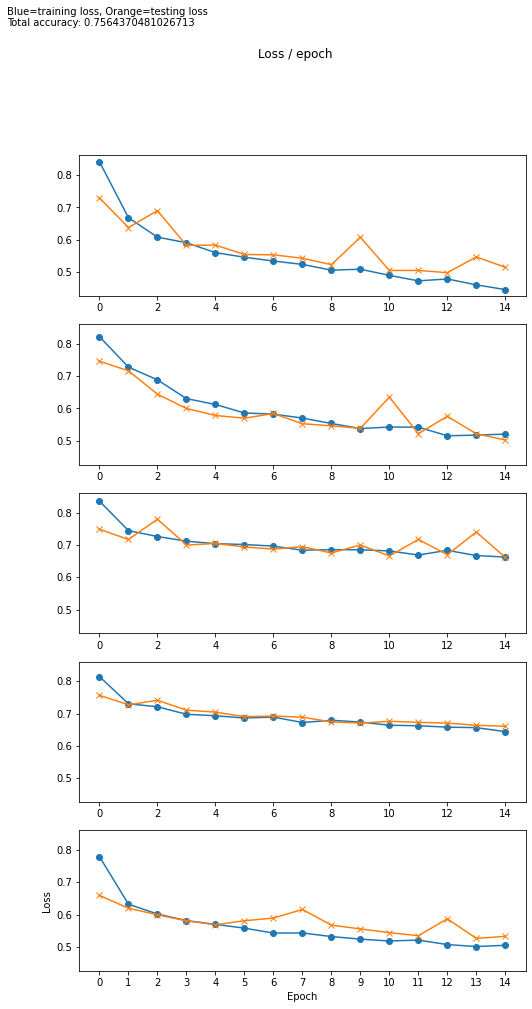

{'batch_size': 32, 'child_counter': 5, 'children_of_child_counter': 1, 'neurons': 16, 'bias': 1, 'activation': 'relu', 'loss': 'cross entropy loss', 'optimizer': 'adamw', 'layers': 3, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'epochs': 15, 'mean': (0.6495729088783264, 0.6495729088783264, 0.6495729088783264), 'std': (0.2604725658893585, 0.2604725658893585, 0.2604725658893585), 'training_loss': [[0.8411545223898167, 0.6681119590926228, 0.6081948794192261, 0.5909030707620031, 0.5603444789953941, 0.5460403593038198, 0.5343669662229734, 0.52388497768975, 0.5061312596932304, 0.5089949679603394, 0.4900341316950407, 0.47298677669440525, 0.4789077816106718, 0.46063245886521376, 0.44600316964322145], [0.8219738355357584, 0.7279096045654169, 0.6884865515666614, 0.6305161687395842, 0.6124486221398096, 0.5861265502816482, 0.5826148006984656, 0.5703826740348368, 0.5536420170923503, 0.5381182347841972, 0.5425713478947143, 0.5423825516117563, 0.5156817265051447, 0.5176043328907278, 0.52094114820

In [5]:
fig, axs = plt.subplots(5, sharey=True)

fig.suptitle('Loss / epoch')
fig.set_figheight(15)
fig.set_figwidth(8)

for i in range(len(parameters['training_loss'])):
  x = range(len(parameters['training_loss'][i]))
  axs[i].plot(x, parameters['training_loss'][i], '-o')
  axs[i].plot(x, parameters['testing_loss'][i], '-x')

x = range(len(parameters['testing_loss']))

plt.xticks(range(len(parameters['training_loss'][i])))

plt.ylabel('Loss')
plt.xlabel('Epoch')

parameters['total_accuracy'] = np.mean(parameters['evaluation_accuracy'])
# Parameters
plt.figtext(0, 1, f'Total accuracy: {parameters["total_accuracy"]}', wrap=True)
plt.figtext(0, 1.01, 'Blue=training loss, Orange=testing loss', wrap=True)
  
plt.show()

print(parameters)

print(f"Total accuracy: {parameters['total_accuracy']}")